## 5.4 自転車レンタル予測 (その1)

オリジナルURL   
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

#### データ項目メモ

instant インデックス  
dteday 日付(yy-mm-dd)  
season 季節 (1: 冬 2: 春 3: 夏 4:秋)  
yr 年 (0: 2011, 1:2012)  
mnth 月  (1 - 12)  
hr 時間  (0 - 23)  
holiday 祝日  
weekday 曜日 (0 - 6)  
workingday  勤務日 (1: 勤務日 0: 休日)  
weathersit 天気 (1: 晴れから曇り 2: 霧 3: 小雨 4: 大雨)  
temp 気温 (正規化済み)  
atemp 体感気温 (正規化済み)  
hum 湿度 (正規化済み)  
windspeed 風速 (正規化済み)  
casual 臨時利用者数  
registered 登録利用者数  
cnt 全体利用者数  

### 共通事前処理

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# データフレームでの表示精度
pd.options.display.float_format = '{:.4f}'.format
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

### 5.4.3 データ読み込みからデータ確認まで

#### (1) データ読み込み

In [3]:
# ダウンロード元URL
url = 'https://archive.ics.uci.edu/ml/\
machine-learning-databases/00275/\
Bike-Sharing-Dataset.zip'

# 公開データのダウンロードと解凍
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

--2020-06-22 17:59:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 279992 (273K) [application/x-httpd-php]
`Bike-Sharing-Dataset.zip' に保存中

Bike-Sharing-Datase 100%[===================>] 273.43K  54.6KB/s 時間 5.0s       

2020-06-22 17:59:18 (54.6 KB/s) - `Bike-Sharing-Dataset.zip' へ保存完了 [279992/279992]

  inflating: hour.csv                


In [4]:
# データの状態確認
!head -5 day.csv

In [75]:
# day.csvをデータフレームに取り込み
# 日付を表す列はparse_datesで指定する
df = pd.read_csv('day.csv', parse_dates=[1])

# データ属性の確認
print(df.dtypes)

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [76]:
# instant は連番で予測で不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化

columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気', 
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'
]

# 項目名を日本語に置き換え
df.columns = columns

#### (2) データ確認

In [77]:
# 先頭5行の確認
display(df.head())

# 最終5行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


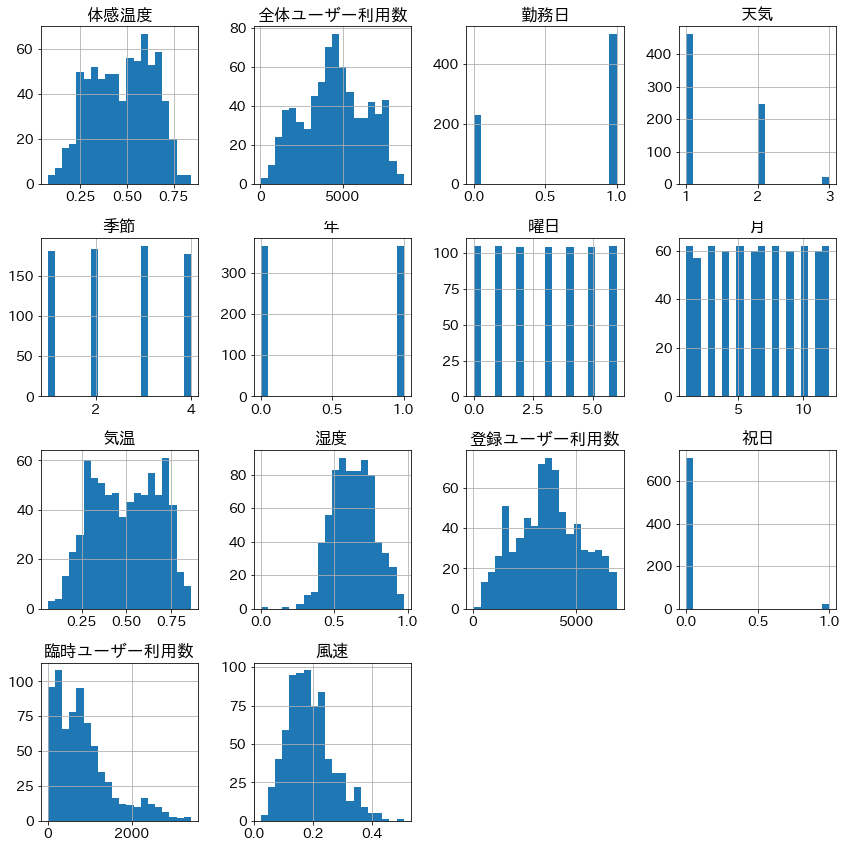

In [78]:
# 度数分布表示

# グラフのサイズ調整のためのおまじない
from pylab import rcParams
rcParams['figure.figsize'] = (12, 12)

# データフレームの数値項目でヒストグラム表示
df.hist(bins=20)
plt.tight_layout()
plt.show()

In [80]:
# 欠損値チェック
df.isnull().sum()

日付           0
季節           0
年            0
月            0
祝日           0
曜日           0
勤務日          0
天気           0
気温           0
体感温度         0
湿度           0
風速           0
臨時ユーザー利用数    0
登録ユーザー利用数    0
全体ユーザー利用数    0
dtype: int64

#### 時系列データのグラフ表示

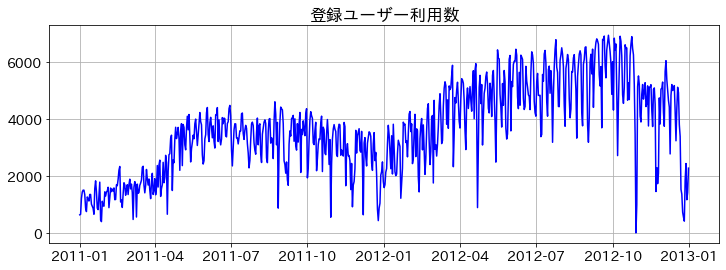

In [99]:
# 時系列グラフの描画 (登録利用者数)
plt.figure(figsize=(12,4))

# グラフ描画
plt.plot(df['日付'],df['登録ユーザー利用数'],c='b')

# 方眼表示など
plt.grid()
plt.title('登録ユーザー利用数')

# 画面出力
plt.show()

### 5.4.4 データ前処理とデータ分割

#### (3) データ前処理
(特になし)

#### (4) データ分割

方針
* 目的変数yは「登録ユーザー利用数」とする
* 「全体ユーザー利用数」と「臨時ユーザー利用数」は対象から落とす
* 日付も入力変数として不要なので入力変数xから落とす
* 時間軸に関しては 2012-11-01より前を訓練データ、後ろを検証データとする

In [83]:
# x, yへの分割
x = df.drop(['日付', '臨時ユーザー利用数', '登録ユーザー利用数',
    '全体ユーザー利用数'], axis=1)
y = df['登録ユーザー利用数'].values

In [84]:
# 分割日 mdayの設定
mday = pd.to_datetime('2012-11-1')

# 訓練用indexと検証用indexを作る
train_index = df['日付'] < mday
test_index = df['日付'] >= mday

# 入力データの分割
x_train = x[train_index]
x_test = x[test_index]

# yも同様に分割
y_train = y[train_index]
y_test = y[test_index]

# 日付データの分割(グラフ表示用)
dates_test = df['日付'][test_index]

In [85]:
# 結果確認(サイズを確認)
print(x_train.shape)
print(x_test.shape)

# 結果確認 (境界値を重点的に)
display(x_train.tail())
display(x_test.head())

(670, 11)
(61, 11)


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
665,4,1,10,0,6,0,2,0.5300,0.5151,0.7200,0.2357
666,4,1,10,0,0,0,2,0.4775,0.4678,0.6946,0.3980
667,4,1,10,0,1,1,3,0.4400,0.4394,0.8800,0.3582
668,4,1,10,0,2,1,2,0.3182,0.3099,0.8255,0.2130
669,4,1,10,0,3,1,2,0.3575,0.3611,0.6667,0.1667


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
670,4,1,11,0,4,1,2,0.3658,0.3699,0.5817,0.1573
671,4,1,11,0,5,1,1,0.3550,0.3560,0.5221,0.2662
672,4,1,11,0,6,0,2,0.3433,0.3238,0.4913,0.2705
673,4,1,11,0,0,0,1,0.3258,0.3295,0.5329,0.1791
674,4,1,11,0,1,1,1,0.3192,0.3081,0.4942,0.2363


In [86]:
# 目的変数の分割結果確認
print(y_train[:10])

[ 654  670 1229 1454 1518 1518 1362  891  768 1280]


### 5.4.5 アルゴリズム選定

#### (5) アルゴリズム選定

In [87]:
# アルゴリズム選定
# XGBRegressorを選定する
from xgboost import XGBRegressor
algorism = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

### 5.4.6 学習・予測

In [88]:
# 登録ユーザー利用数予測モデルの学習と予測

# (6) 学習
algorism.fit(x_train, y_train)

# (7) 予測
y_pred = algorism.predict(x_test)

# 予測結果確認
print(y_pred[:5])

[4613.577  4863.4756 4057.923  3642.1284 4354.408 ]


### 5.4.7 評価

In [89]:
# (8) 評価(登録ユーザー利用数)

# score関数の呼び出し
score = algorism.score(x_test, y_test)

# R2値の計算
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, y_pred)

# 結果確認
print(f'score: {score:.4f}  r2_ score: {r2_score:.4f}')

score: 0.5294  r2_ score: 0.5294


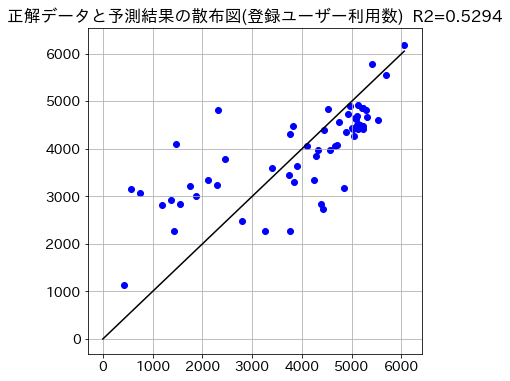

In [90]:
#正解データと予測結果を散布図で比較 (登録ユーザー利用数)
plt.figure(figsize=(6,6))
y_max = y_test.max()
plt.plot((0,y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred, c='b')
plt.title(f'正解データと予測結果の散布図(登録ユーザー利用数)  R2={score:.4f}')
plt.grid()
plt.show()

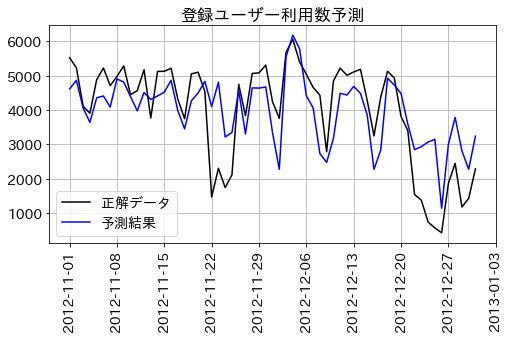

In [91]:
# 時系列グラフの描画 (登録ユーザー利用数)
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, y_test, label='正解データ', c='k')
ax.plot(dates_test, y_pred, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測')

# 画面出力
plt.show()

### 5.4.8 チューニング

In [92]:
# 項目をone hot encodeするための関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column],axis=1),df_dummy],axis=1)
    return df

# 項目「月」「季節」をone hot encodingする

x2 = x.copy()
x2 = enc(x2, '月')
x2 = enc(x2, '季節')

# 結果確認
display(x2.head())

,年,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,月_1,月_2,月_3,月_4,月_5,月_6,月_7,月_8,月_9,月_10,月_11,月_12,季節_1,季節_2,季節_3,季節_4
0,0,0,6,0,2,0.3442,0.3636,0.8058,0.1604,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,2,0.3635,0.3537,0.6961,0.2485,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,1,0.1964,0.1894,0.4373,0.2483,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,2,1,1,0.2000,0.2121,0.5904,0.1603,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,3,1,1,0.2270,0.2293,0.4370,0.1869,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [93]:
# 登録利用者モデル(チューニング後)

# (4) mdayを基準に入力データを分割
x2_train = x2[train_index]
x2_test = x2[test_index]

#　(5) アルゴリズム選定
algorism2 = XGBRegressor(objective ='reg:squarederror',
    random_state=random_seed)

# (6) 学習
algorism2.fit(x2_train, y_train)

# (7) 予測
y_pred2 = algorism2.predict(x2_test)

# 予測結果確認
print(y_pred2[:5])

[4509.6143 4841.9644 3852.8997 3567.8196 4280.041 ]


In [94]:
# (8) 評価(登録利用者) (チューニング後)

# score関数の呼び出し
score2 = algorism2.score(x2_test, y_test)

# 結果確認
print(f'score: {score2:.4f}')

score: 0.6182


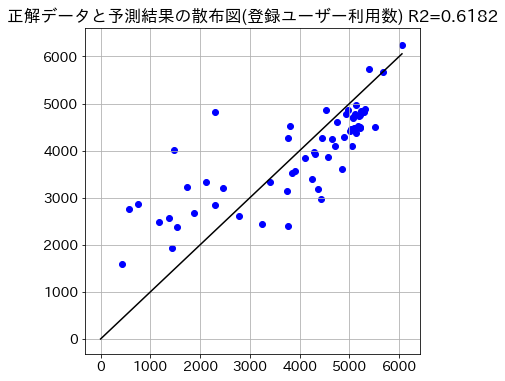

In [95]:
#正解データと予測結果を散布図で比較 (登録利用者)
plt.figure(figsize=(6,6))
y_max = y_test.max()
plt.plot((0,y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred2, c='b')
plt.title(f'正解データと予測結果の散布図(登録ユーザー利用数) R2={score2:.4f}')
plt.grid()
plt.show()

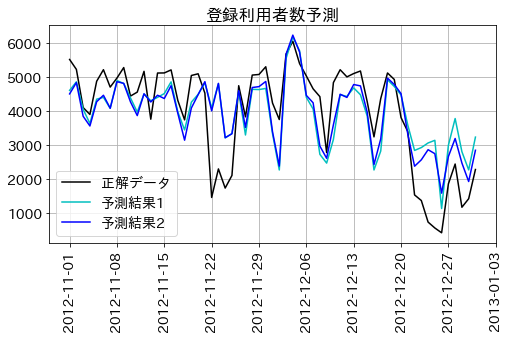

In [100]:
# 時系列グラフの描画 (チューニング後 登録ユーザー利用数)
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 4))

# グラフ描画
ax.plot(dates_test, y_test, label='正解データ', c='k')
ax.plot(dates_test, y_pred, label='予測結果1', c='c')
ax.plot(dates_test, y_pred2, label='予測結果2', c='b')

# 日付目盛間隔
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付書式
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録利用者数予測')

# 画面出力
plt.show()

### 5.4.9 重要度分析

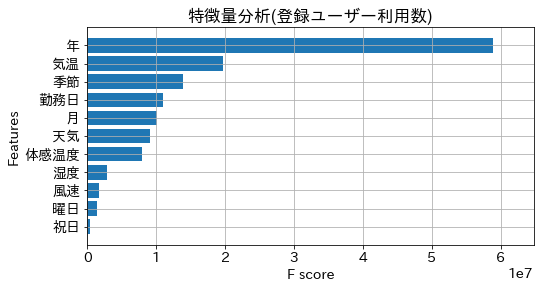

In [98]:
# 登録ユーザー利用数に対する重要度分析
import xgboost as xgb
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(algorism, ax=ax, height=0.8,
    importance_type='gain', show_values=False,
    title='重要度分析(登録ユーザー利用数)')
plt.show()